# Bad results with VPG

In [1]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
import gymnasium as gym
import numpy as np
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal

In [2]:
class PolicyNetwork(nn.Module):
    # forward() returns 2 heads: mean and log(standard deviation)
    # log(std) head is used, allowing logits to be real values. recover std through e^(log std). why not abs(std)? it's sharp.
    
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(3, 64)          # shared backbone
        self.fc2 = nn.Linear(64, 64)         # shared backbone
        self.mean_head = nn.Linear(64, 1)    # policy head
        self.log_std_head = nn.Linear(64, 1) # policy head 
        nn.init.constant_(self.log_std_head.weight, 0.0)  # stabilize start by initializing with std of 1
        nn.init.constant_(self.log_std_head.bias, 0.0)
    
    def forward(self, x):  # tensor[m, 3] -> tuple[tensor[m, 1], tensor[m, 1]], where m = batch dim (timesteps in this case)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        mean = self.mean_head(x)
        log_std = self.log_std_head(x)
        log_std = -20 + F.softplus(log_std + 20)  # soft clip lower bound
        log_std = 2 - F.softplus(2 - log_std)     # soft clip upper bound
        return mean, log_std


class CriticNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(3, 128)
        self.fc2 = nn.Linear(128, 1)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [33]:
def run_episode(env, policy: PolicyNetwork, max_steps: int = 99999) -> tuple:
    states = []
    actions = []
    rewards = []
    state, _ = env.reset()
    for steps in range(1, max_steps+1):
        x = torch.as_tensor(state, dtype=torch.float)
        with torch.no_grad():
            mean, log_std = policy(x)
        std = log_std.exp()
        dist = Normal(mean, std)
        action = dist.sample()  # sample 1 value from the distribution
        action = action.clip(-2, 2)  # clip to env action bounds
        next_state, reward, terminated, truncated, _ = env.step(action)
        states.append(state)
        actions.append(action)
        rewards.append(reward)
        state = next_state
        if terminated or truncated:
            break
    return np.array(states), np.array(actions), np.array(rewards), steps

In [34]:
def calc_returns(rewards: torch.tensor, gamma: int) -> torch.tensor:
    """Calculates discounted return (G_t) at every timestep t using `rewards` from a rollout"""
    T = len(rewards)
    discounted = torch.zeros(T)
    r = 0
    for t in reversed(range(T)):
        r = rewards[t] + gamma * r
        discounted[t] = r
    return discounted

In [35]:
policy = PolicyNetwork()
critic = CriticNetwork()

In [44]:
try: env.reset(), env.close()
except: pass
env = gym.make('Pendulum-v1')

In [45]:
gamma = 0.99
lr = 1e-4
policy_optimizer = optim.Adam(policy.parameters(), lr=lr)
critic_optimizer = optim.Adam(critic.parameters(), lr=lr)

time 113.19 s


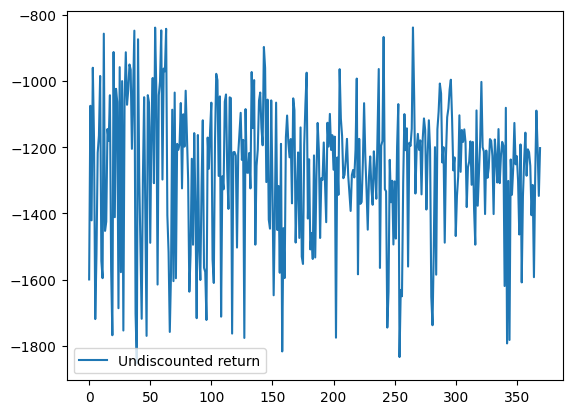

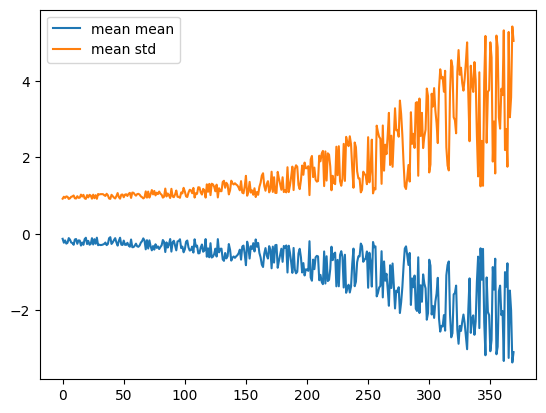

In [ ]:
undiscounted_history = []
mean_history = []
std_history = []
try:
    t0 = time.time()
    for episode in range(1, 3000+1):
        state, _ = env.reset()
        states, actions, rewards, steps = run_episode(env, policy)
        
        states = torch.as_tensor(states)                   # [T, 3]
        actions = torch.as_tensor(actions).reshape(-1, 1)  # [T, 1]
        rewards = torch.as_tensor(rewards)                 # [T]
        
        values = critic(states).squeeze()  # [T]

        returns = calc_returns(rewards, gamma)  # [T], discounted returns for each timestep i.e. list of G_0, G_1, ..., G_{T-1}
        advantages = returns - values.detach()  # make sure that actor backward does not affect critic
        
        # policy (actor) loss
        mean, log_std = policy(states)  # mean: [T, 1]
        std = log_std.exp()             # std : [T, 1]
        dist = Normal(mean, std)  # batched distribution of size T, constructed from policy heads
        log_probs = dist.log_prob(actions).squeeze(1)  # [T], computes log(policy(a|s)) for all actions taken
        policy_loss = -(log_probs * advantages).sum()  # [] scalar

        # critic loss
        critic_loss = F.mse_loss(values, returns)  # critic trained on Monte Carlo return

        policy_optimizer.zero_grad()
        policy_loss.backward()
        torch.nn.utils.clip_grad_norm_(policy.parameters(), max_norm=1.0)
        policy_optimizer.step()

        critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(critic.parameters(), max_norm=1.0)
        critic_optimizer.step()
        
        undiscounted_history.append(rewards.sum().item())
        mean_history.append(mean.mean().item())
        std_history.append(std.mean().item())
        
        if episode % 10 == 0:
            clear_output(wait=True)
            print(f'time {time.time() - t0:.2f} s')
            plt.plot(undiscounted_history, label='Undiscounted return')
            plt.legend()
            plt.show()
            plt.plot(mean_history, label='mean mean')
            plt.plot(std_history, label='mean std')
            plt.legend()
            plt.show()
            
except KeyboardInterrupt:
    print('-')

In [40]:
env.close()

In [41]:
# play
env = gym.make('Pendulum-v1', render_mode='human')
_, _, _, steps = run_episode(env, policy)
print(steps)
env.close()

200


In [172]:
# save
import os
os.makedirs('./saved/tstr1/tstr2', exist_ok=True)
torch.save(policy.state_dict(), './saved/Pendulum.pth')